##Loading files from drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
import os
os.getcwd()

'/content/drive/My Drive'

In [0]:
os.chdir('Colab Notebooks/zmn_stch/zaman deep short/yolo_f')

In [0]:
os.chdir('My Drive')

In [9]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/zmn_stch/zaman deep short/yolo_f'

In [10]:
!ls

cd	       LICENSE		  test_frame.png  yolo.py
convert.py     model_data	  testgpu.py	  yolo.pyc
deep_sort      __pycache__	  tools		  yolov3.cfg
demo.py        qmul_junction.png  video.mp4	  yolov_deepsort.ipynb
detection.txt  README.md	  Viz
gpudevices.py  Results		  yolo3


In [12]:
%cd My\ Drive/Colab Notebooks/zmn_stch/zaman deep short/yolo_f

[Errno 2] No such file or directory: 'My Drive/Colab Notebooks/zmn_stch/zaman deep short/yolo_f'
/content


In [13]:
%cd /content/drive/My\ Drive/BTP/Code/Deep\ Sort\ and\ Yolov/deep_sort_yolov3
%ls

[Errno 2] No such file or directory: '/content/drive/My Drive/BTP/Code/Deep Sort and Yolov/deep_sort_yolov3'
/content
cd             LICENSE            test_frame.png  yolo.py
convert.py     model_data/        testgpu.py      yolo.pyc
deep_sort/     __pycache__/       tools/          yolov3.cfg
demo.py        qmul_junction.png  video.mp4       yolov_deepsort.ipynb
detection.txt  README.md          Viz/
gpudevices.py  Results/           yolo3/


# Imports and Defaults

In [14]:
from __future__ import division, print_function, absolute_import

import os
from timeit import time
import warnings
import sys
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output

from PIL import Image
from yolo import YOLO

from deep_sort import preprocessing
from deep_sort import nn_matching
from deep_sort.detection import Detection
from deep_sort.tracker import Tracker
from tools import generate_detections as gdet
from deep_sort.detection import Detection as ddet

from scipy.spatial import distance
from sklearn.linear_model import LinearRegression
import collections
from scipy.spatial.distance import seuclidean #imports abridged
import scipy
import scipy.stats as st
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

MAX_COSINE_DISTANCE = 0.3
NN_BUDGET = None
NMS_MAX_OVERLAP = 1.0

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


# Getting YOLO Object

In [15]:
yolo = YOLO()








model_data/yolo.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Definition of the parameters

[What these params are?](https://github.com/nwojke/deep_sort/blob/master/deep_sort/nn_matching.py)

[max_bbox_overlap](https://github.com/nwojke/deep_sort/blob/master/application_util/preprocessing.py)


        matching threshold: Samples with larger distance are considered an
        invalid match.
        
        budget : int
        If not None, fix samples per class to at most this number. Removes
        the oldest samples when the budget is reached.
        
        max_bbox_overlap : float
        ROIs that overlap more than this values are suppressed.

In [0]:
matching_threshold = 0.2
nn_budget = None
nms_max_overlap = 0.7


# deep_sort 

In [17]:
model_filename = 'model_data/mars-small128.pb'
encoder = gdet.create_box_encoder(model_filename,batch_size=1)

metric = nn_matching.NearestNeighborDistanceMetric("cosine", matching_threshold, nn_budget)
tracker = Tracker(metric)

# Input Video File

In [18]:
input_file_name = 'video'
input_file_format='.mp4'
path =input_file_name+input_file_format
video_capture = cv2.VideoCapture("video.mp4" )

width_video_frame = int(video_capture.get(3))
height_video_frame = int(video_capture.get(4))
print(height_video_frame,width_video_frame)

288 360


# Trajectory Dataset Output Folder

In [0]:
name = 'v1'

In [24]:
out_directory = './Results/'+input_file_name+'_'+name
if not os.path.exists(out_directory):
    os.mkdir(out_directory)
    print("Directory " , out_directory ,  " Created ")
else:
    print("Directory " , out_directory ,  " already exists")
    
#trajectories folder
out_trajectories_directory = out_directory+'/Trajectories'   
if not os.path.exists(out_trajectories_directory):
    os.mkdir(out_trajectories_directory)
    print("Directory " , out_trajectories_directory ,  " Created ")
else:
    print("Directory " , out_trajectories_directory ,  " already exists")
    

Directory  ./Results/video_v1  Created 
Directory  ./Results/video_v1/Trajectories  Created 


##  Saving HyperParameters

In [0]:
from configparser import SafeConfigParser

config = SafeConfigParser()
config.read('config.ini')
config.add_section('Video')
config.set('Video', 'path', path)
config.add_section('NN_Matching')
config.set('NN_Matching', 'matching_threshold', str(matching_threshold))
config.set('NN_Matching', 'nn_budget', str(nn_budget))
config.add_section('Preprocessing')
config.set('Preprocessing', 'nms_max_overlap', str(nms_max_overlap))

with open(out_directory+'/'+'model_config.ini', 'w') as f:
    config.write(f)



#Crop Parameters

## Judging the crop frame

In [27]:
!ls


cd	       LICENSE		  test_frame.png  yolo.py
convert.py     model_data	  testgpu.py	  yolo.pyc
deep_sort      __pycache__	  tools		  yolov3.cfg
demo.py        qmul_junction.png  video.mp4	  yolov_deepsort.ipynb
detection.txt  README.md	  Viz
gpudevices.py  Results		  yolo3


(288, 360, 3)


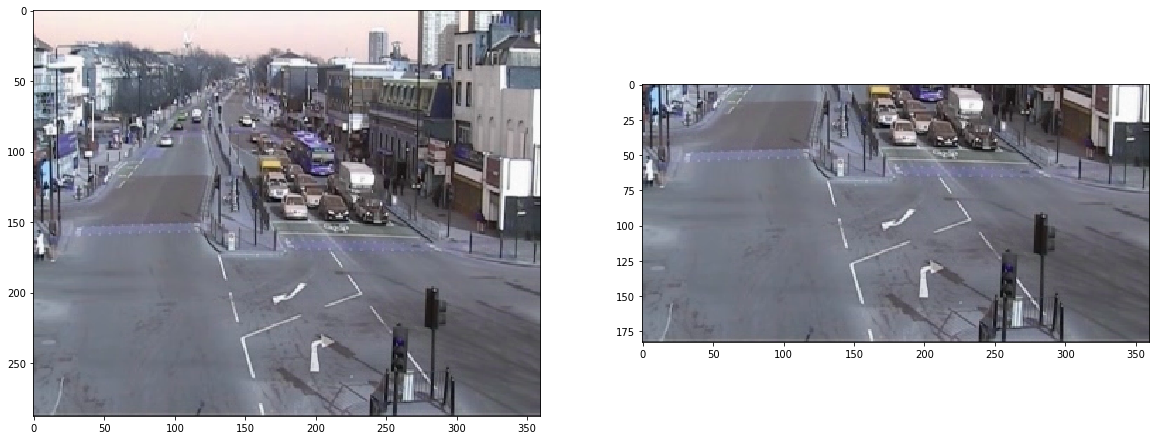

In [28]:
# test_frame = cv2.imread('test_frame.png')
test_frame = cv2.imread('qmul_junction.png')

plt.figure(figsize=(20,24))
plt.subplot(1, 2, 1)
plt.imshow(test_frame)
print(test_frame.shape)

c_start_h, c_end_h = 105,height_video_frame
c_start_w, c_end_w = 0, width_video_frame

# crop_frame = test_frame[100:height_video_frame, 0:615]
crop_frame = test_frame[c_start_h:c_end_h, c_start_w:c_end_w]
plt.subplot(1, 2, 2)
plt.imshow(crop_frame)
plt.show()


## Crop Parameters

In [0]:
crop_flag = True

In [0]:
if crop_flag:
  ( height_start , width_start )  = (c_start_h, c_start_w)
  ( height_end,  width_end ) = (c_end_h , c_end_w)

## Function 

In [0]:
def crop_frame(frame, height_start, width_start, height_end, width_end):
  return frame[height_start:height_end, width_start:width_end]

# Generate Output Video

In [0]:
writeVideo_flag = True

In [0]:
height_end=288
height_start=0
width_end=360
width_start=0
crop_flag=0

In [0]:
if writeVideo_flag:
# Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
  
    output_video_height = height_end-height_start
    output_video_width = width_end - width_start
    
    if crop_flag:
      out = cv2.VideoWriter(out_directory+'/output_'+input_file_name+'.avi', fourcc, 15, (output_video_width, output_video_height))
    else:
      out = cv2.VideoWriter(out_directory+'/output_'+input_file_name+'.avi', fourcc, 15, (width_video_frame, height_video_frame))
    
    frame_index = -1 

In [0]:
dic_lost={}
dic_run={}
g={}
dic_len=10  # len of vector for angle
gamma=25    # number of frames consindering 
thresh=80   # stitching distance
mingle=0.7  # max angle change by object (in cosine)


#Extract Trajectories

In [36]:
# dic[object] is a list, [0] is last frame number, [1] is the deque, [2] is the linear regression
# dic_len=30

def angle_between(v1, v2):
    # Returns the angle in radians between vectors 'v1' and 'v2'::
    return 1-scipy.spatial.distance.cosine(v1,v2)
  
def f_angle(T,u,v,x,y,a,b):
    q=T.predict(   (np.ones([1,1])*a ))
    q=q[0]
    q1=T.predict((np.ones([1,1])*b))
    q1=q1[0]
    f=angle_between((q1-q,b-a),(v-y,u-x))
    return f
def p_dis(u,v,tt,T,x0,x1,Ti):
    t0=Ti[0]
    t1=Ti[-1]
    if(t1!=t0):
      xn=((x1-x0)/(t1-t0))*(tt-t0)+x0
    else:
      xn=x0
    yn=T.predict(   (np.ones([1,1])*xn ))
    if xn>=500 or yn >=500:
      xn=0
      tn=0
    else:
      d=distance.euclidean((u,v),(xn,yn))
    return (st.norm(0,100).cdf(d)-st.norm(0, 100).cdf(0))*2
def p_ngle(angle):
    return (st.norm(0,1).cdf(1-angle)-st.norm(0, 1).cdf(0))*2
fps = 0.0
while True:
    ret, frame = video_capture.read()  # frame shape 640*480*3
    #print(ret)
    if ret != True:
        break;
        
    t1 = time.time()
    
    if crop_flag:
      frame = crop_frame(frame, height_start ,width_start , height_end, width_end)
    
    image = Image.fromarray(frame)
    boxs = yolo.detect_image(image)
    features = encoder(frame,boxs)

    # score to 1.0 here).
    detections = [Detection(bbox, 1.0, feature) for bbox, feature in zip(boxs, features)]

    # Run non-maxima suppression.
    boxes = np.array([d.tlwh for d in detections])
    scores = np.array([d.confidence for d in detections])
    indices = preprocessing.non_max_suppression(boxes, nms_max_overlap, scores)
    detections = [detections[i] for i in indices]


    print(t1)


    l=[]
    # Call the tracker
    tracker.predict()
    tracker.update(detections)
    for track in tracker.tracks:
        if not track.is_confirmed() or track.time_since_update > 1:
            continue
        bbox = track.to_tlbr()
        o = int(track.track_id)
        x = int(bbox[0]+(bbox[2]-bbox[0])/2)
        y = int(bbox[1]+(bbox[3]-bbox[1])/2)
        if(dic_run.get(o)!=None) :
          dic_run[o][0]=frame_index
          dic_run[o][1].append((x,y,t1))
          if(len(dic_run[o][1])>dic_len) :
            dic_run[o][1].popleft()
        elif(dic_lost.get(o)!=None) :
          dic_run[o]=dic_lost[o]
          del dic_lost[o]
          dic_run[o][1].append((x,y,t1))
          if(len(dic_run[o][1])>dic_len) :
            dic_run[o][1].popleft() 
        else :
          l.append([o,x,y,t1])
    #print(l)
    temp=[]
    temp_2=[]
    for key in dic_run.keys() :
        if(dic_run[key][0]<frame_index) :
            temp.append(key)
            dic_lost[key]=dic_run[key]
    for key in dic_lost.keys():
        if(dic_lost[key][0]<frame_index-gamma):
            temp_2.append(key)
    for i in temp:
        del dic_run[i]
    for i in temp_2:
        del dic_lost[i]
    
    
    #print(len(l))
    #print ( len(dic_lost.keys()  ))
     #print(   len(dic_lost)  )
    
    for i in range(0,len(l)) :
      t=None
      mingle=0.6
      #print(l[i][0])
      u=l[i][1]
      v=l[i][2]
      tt=l[i][3]
      mini=1
      for key in dic_lost.keys() :
        x=dic_lost[key][1][-1][0]
        y=dic_lost[key][1][-1][1]
     
        if(distance.euclidean((u,v),(x,y))<thresh) :    
              #X=dic_lost[key][1][:][0]
              #Y=dic_lost[key][1][:][1]
          q=list(collections.deque(dic_lost[key][1]))
          X=[]
          Y=[]
          Ti=[]
          for j in range(0,len(q)) :
            X.append(q[j][0])
            Y.append(q[j][1])
            Ti.append(q[j][2])
          #print(q,end="\t")
          #print(q,end="\t")
          X=np.asarray(X)
          Y=np.asarray(Y)
          Ti=np.asarray(Ti)
          #print(X,end="    ")
          #print(Y,end="    ")
          a=X[0]
          if(len(X)>1):
            b=X[-1]
          else:
            b=0
          T=LinearRegression()
          T.fit(X[:,np.newaxis],Y[:,np.newaxis])
          
          #print(l[i],end=" ")
          #print(key,end=" ")
          #print(distance.euclidean((u,v),(x,y)),end=" ")
          #print(   f_angle(T,u,v,x,y,a,b)    )
          
          if(f_angle(T,u,v,x,y,a,b)[0]>mingle) :
            p=p_ngle(f_angle(T,u,v,x,y,a,b)[0])
            p=p*p_dis(u,v,tt,T,a,b,Ti)
            if(mini>p):
               t=key
               mini=p
            
      if(t==None) :
        dic_run[l[i][0]]=[frame_index,collections.deque([(u,v,tt)])]
        g[l[i][0]]=l[i][0]
      else :
        del dic_lost[t]
        #dic_run[t][0]=frame_index
        #dic_run[t][1].popleft()
        #dic_run[t][1].append((u,v))
        dic_run[l[i][0]]=[frame_index,collections.deque([(u,v,tt)])]
        g[l[i][0]]=g[t] 
        
     
          
          
          
          
    for track in tracker.tracks:
        if not track.is_confirmed() or track.time_since_update > 1:
            continue 
        bbox = track.to_tlbr()
        
        #draw rectangle
        #cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),(255,255,255), 2)

        #create trajectory file
        object_file = open(out_trajectories_directory+'/'+str(g.get(track.track_id,track.track_id))+'.txt', 'a')

        x = int(bbox[0]+(bbox[2]-bbox[0])/2)
        y = int(bbox[1]+(bbox[3]-bbox[1])/2)
        cv2.putText(frame, str(g.get(track.track_id,track.track_id)),(x, y),0, 5e-3 * 200, (0,255,0),2)
        
        x_limit = frame.shape[1]
        y_limit = frame.shape[0]
        
        if x<=x_limit and y <=y_limit:
          
            object_file.write(str(x)+ '\t'+str(y)+'\t'+str(frame_index)+'\n') 
            cv2.circle(frame,(x,y), 3, (0,0,255), -1)
           
    for det in detections:
        bbox = det.to_tlbr()
    
    if writeVideo_flag:
        # save a frame
        out.write(frame)
        frame_index = frame_index + 1

    fps  = ( fps + (1./(time.time()-t1))) / 2
    #print(fps)

video_capture.release()
if writeVideo_flag:
    out.release()
    
print (g)

  
  



        
    
    
    
    




1570007788.610545
1570007795.6287436
1570007795.821128
1570007796.0556283
1570007796.2767096
1570007796.4996452
1570007796.7075474
1570007796.9306662
1570007797.1217544
1570007797.3115587
1570007797.5163548
1570007797.7072306
1570007797.8999672
1570007798.1113322
1570007798.3086867
1570007798.5126991
1570007798.70621
1570007798.898971
1570007799.1134303
1570007799.3037136
1570007799.5246515
1570007799.7220104
1570007799.9297714
1570007800.154793
1570007800.3663135
1570007800.5900464
1570007800.7955723
1570007801.0190878
1570007801.2050679
1570007801.3981912
1570007801.605512
1570007801.8012288
1570007802.01371
1570007802.2041895
1570007802.389905
1570007802.5906982
1570007802.7874808
1570007803.0065076
1570007803.2345061
1570007803.448868
1570007803.6608074
1570007803.8538685
1570007804.05087
1570007804.2595203
1570007804.4553137
1570007804.647854
1570007804.8484125
1570007805.036899
1570007805.2456713
1570007805.4440336
1570007805.653124
1570007805.8398297
1570007806.053835
1570007806

In [0]:
()-print(boxs)

[[146, 83, 13, 16], [162, 112, 15, 16], [176, 107, 16, 14], [226, 126, 23, 23], [92, 73, 12, 11], [156, 75, 9, 8], [159, 88, 9, 10], [102, 86, 12, 8], [166, 128, 21, 20], [92, 107, 17, 13], [106, 95, 13, 8]]


TypeError: ignored

In [0]:
print(out_trajectories_directory)

./Results/video_v1/Trajectories


#Minimum Length Of Trajectory

307.94552658190884


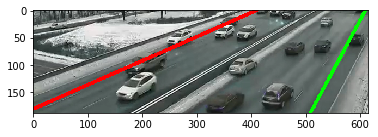

In [0]:
import math
test_frame = cv2.imread('test_frame.png')

crop_frame = test_frame[100:height_video_frame, 0:615]


# Draw lanes
cv2.line(crop_frame,(0,180),(410,0),(255,0,0),5)

cv2.line(crop_frame,(610,0),(440,315),(0,255,0),5)

# dist = math.hypot(x2 - x1, y2 - y1)
min_length = min(math.hypot(440 - 610, 315 - 0),math.hypot(410 - 0, 0 - 180) )
min_length = min_length-50
print(min_length)
plt.imshow(crop_frame)
plt.show()

# Trajectory Preprocessing

In [0]:
!ls ./Results/93_v1

ls: cannot access './Results/93_v1': No such file or directory


In [0]:
refined_trajectories_directory = out_directory+'/Refined_Trajectories' 

if not os.path.exists(refined_trajectories_directory):
    os.mkdir(refined_trajectories_directory)
    print("Directory " , refined_trajectories_directory ,  " Created ")
else:
    print("Directory " , refined_trajectories_directory ,  " already exists")

Directory  ./Results/video_v1/Refined_Trajectories  Created 


In [0]:
for filename in os.listdir(out_trajectories_directory):
  if filename.endswith(".txt"):
      dat = np.loadtxt(out_trajectories_directory+'/'+filename)
      start_x, start_y =  dat[0,0], dat[0,1]
      end_x , end_y = dat[-1,0], dat[-1,1]
      length = math.hypot(end_x - start_x, end_y - start_y)
      if(length> min_length):
        np.savetxt(refined_trajectories_directory+'/'+filename.split('.')[0]+'.txt',dat,fmt='%i')


IndexError: ignored

##Stiching

In [0]:
for filename in os.listdir(out_trajectories_directory):
  if filename.endswith(".txt"):
      data = np.loadtxt(out_trajectories_directory+'/'+filename,dtype='int')
      
#       x = dat[:,0].astype( np.uint8 )  # this is the X column as float
#       y = dat[:,1].astype( np.uint8 )  # this is the Y column as float
#       f = dat[:,2].astype( np.uint8 )  # this is the F column as int
      
      start_x ,start_y, start_f =  data[0,0], data[0,1], data[0,2]
      end_x , end_y, end_f = data[-1,0], data[-1,1], data[-1,2]
      
      print((start_x,start_y,start_f),'\t', (end_x, end_y,end_f),' \t', filename.split('.')[0])
      

#Converting to Speed Gradient

#Clustering Trajectories